In [13]:
# =====================================================================
# AST Respiratory Classification - Clean Setup
# =====================================================================

# 1. MOUNT DRIVE & CREATE PROJECT
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
project_root = '/content/drive/MyDrive/AST_Respiratory'
os.makedirs(f"{project_root}/data", exist_ok=True)
os.makedirs(f"{project_root}/models", exist_ok=True)
print(f"✅ Project: {project_root}")

# 2. INSTALL MISSING PACKAGES (SILENT)
import subprocess
import sys

packages = ['librosa', 'kaggle', 'soundfile']
for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '-q'])

# 3. IMPORT LIBRARIES
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print(f"✅ Libraries loaded | GPU: {'Yes' if tf.config.list_physical_devices('GPU') else 'No'}")

# 4. KAGGLE AUTHENTICATION (HANDLES FULL JSON IN SECRETS)
def setup_kaggle():
    """Setup Kaggle - handles both separate secrets and full JSON content"""

    # Check if already configured
    if os.path.exists('/root/.kaggle/kaggle.json'):
        result = os.system('kaggle datasets list --max-size 1 > /dev/null 2>&1')
        if result == 0:
            print("✅ Kaggle: Already configured")
            return True

    print("🔍 Checking Colab Secrets...")

    try:
        from google.colab import userdata

        # Method 1: Check for full JSON content in various secret names
        possible_json_secrets = ['KAGGLE_K', 'KAGGLE_KEY', 'KAGGLE_JSON', 'KAGGLE']

        for secret_name in possible_json_secrets:
            try:
                secret_value = userdata.get(secret_name)
                if secret_value:
                    print(f"✅ Found secret: {secret_name}")

                    # Try to parse as JSON
                    try:
                        kaggle_data = json.loads(secret_value)
                        if 'username' in kaggle_data and 'key' in kaggle_data:
                            print("✅ Parsed kaggle.json from secret!")

                            # Setup Kaggle
                            os.makedirs('/root/.kaggle', exist_ok=True)
                            with open('/root/.kaggle/kaggle.json', 'w') as f:
                                json.dump(kaggle_data, f)
                            os.chmod('/root/.kaggle/kaggle.json', 0o600)

                            # Test authentication
                            result = os.system('kaggle datasets list --max-size 1 > /dev/null 2>&1')
                            if result == 0:
                                print("✅ Kaggle authentication successful!")
                                return True
                            else:
                                print("❌ Authentication failed - check credentials")
                                return False
                    except json.JSONDecodeError:
                        # Not JSON, maybe it's just the key part
                        pass
            except:
                continue

        # Method 2: Check for separate username and key
        try:
            username = userdata.get('KAGGLE_USERNAME')
            key = userdata.get('KAGGLE_KEY')
            if username and key:
                print("✅ Found separate KAGGLE_USERNAME and KAGGLE_KEY")
                os.makedirs('/root/.kaggle', exist_ok=True)
                kaggle_json = {'username': username, 'key': key}
                with open('/root/.kaggle/kaggle.json', 'w') as f:
                    json.dump(kaggle_json, f)
                os.chmod('/root/.kaggle/kaggle.json', 0o600)

                result = os.system('kaggle datasets list --max-size 1 > /dev/null 2>&1')
                if result == 0:
                    print("✅ Kaggle authentication successful!")
                    return True
        except:
            pass

    except Exception as e:
        print(f"❌ Error with Colab Secrets: {e}")

    print("❌ No valid Kaggle credentials found")
    print("💡 Your secret should contain the full kaggle.json content like:")
    print('   {"username": "your_username", "key": "your_api_key"}')
    return False

kaggle_ready = setup_kaggle()

# 5. DOWNLOAD DATASETS (IF KAGGLE READY)
if kaggle_ready:
    print("📥 Downloading datasets...")

    # Download ICBHI
    os.system(f'kaggle datasets download vbookshelf/respiratory-sound-database -p {project_root}/data --unzip -q')

    # Download KAUST
    os.system(f'kaggle datasets download arashnic/lung-dataset -p {project_root}/data --unzip -q')

    # Count files
    icbhi_count = len(list(Path(f"{project_root}/data").rglob("*.wav")))
    print(f"✅ Downloaded {icbhi_count} audio files")
else:
    print("❌ Cannot download - upload your kaggle.json file and re-run")

# 6. PROJECT CONFIG
CONFIG = {
    'PROJECT_ROOT': project_root,
    'SAMPLE_RATE': 16000,
    'DURATION': 5.0,
    'N_MELS': 128,
    'BATCH_SIZE': 32,
    'NUM_CLASSES': 10,
    'CLASS_NAMES': ['Normal', 'Wheeze', 'Crackle', 'Rhonchi', 'Stridor', 'Pleural', 'Bronchial', 'COPD', 'Asthma', 'Pneumonia']
}

with open(f"{project_root}/config.json", 'w') as f:
    json.dump(CONFIG, f, indent=2)

globals()['CONFIG'] = CONFIG

print("🎉 SETUP COMPLETE - Ready for Step 2!")
print("=" * 50)

Mounted at /content/drive
✅ Project: /content/drive/MyDrive/AST_Respiratory
✅ Libraries loaded | GPU: Yes
🔍 Checking Colab Secrets...
✅ Found secret: KAGGLE_KEY
✅ Parsed kaggle.json from secret!
✅ Kaggle authentication successful!
📥 Downloading datasets...
✅ Downloaded 2176 audio files
🎉 SETUP COMPLETE - Ready for Step 2!


In [15]:
# =====================================================================
# AST Step 2 FIXED: Multi-Label Data Harmonization
# FIXES: Proper label mapping and dataset exploration
# =====================================================================

import pandas as pd
import numpy as np
import librosa
from pathlib import Path
import json
import re
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

print("🔧 Step 2 FIXED: Multi-Label Data Harmonization")
print("=" * 60)

# Load project config
with open(f"{CONFIG['PROJECT_ROOT']}/config.json", 'r') as f:
    config = json.load(f)

# =====================================================================
# 1. BETTER DATASET EXPLORATION
# =====================================================================
print("🔍 DEEP Dataset Exploration...")

def explore_datasets_thoroughly():
    """Thoroughly explore both datasets to understand their structure"""

    data_path = Path(config['PROJECT_ROOT']) / 'data'
    print(f"📁 Exploring: {data_path}")

    # Get all directories and files
    all_dirs = [d for d in data_path.rglob("*") if d.is_dir()]
    all_wav_files = list(data_path.rglob("*.wav"))
    all_txt_files = list(data_path.rglob("*.txt"))

    print(f"\n📊 Dataset Overview:")
    print(f"   Total directories: {len(all_dirs)}")
    print(f"   Total WAV files: {len(all_wav_files)}")
    print(f"   Total TXT files: {len(all_txt_files)}")

    # Group files by parent directory
    file_groups = {}
    for wav_file in all_wav_files:
        parent = wav_file.parent.name
        if parent not in file_groups:
            file_groups[parent] = []
        file_groups[parent].append(wav_file)

    print(f"\n📁 Directory Structure:")
    for parent, files in file_groups.items():
        print(f"   {parent}/: {len(files)} WAV files")

        # Show sample filenames to understand patterns
        if len(files) > 0:
            sample_files = [f.name for f in files[:3]]
            print(f"      Samples: {sample_files}")

    return all_wav_files, all_txt_files, file_groups

# Explore datasets thoroughly
all_wavs, all_txts, file_groups = explore_datasets_thoroughly()

# =====================================================================
# 2. IDENTIFY REAL DISEASE CATEGORIES
# =====================================================================
print("\n🎯 Identifying Disease Categories...")

def identify_disease_patterns():
    """Identify disease patterns from filenames and directories"""

    disease_patterns = {
        'normal': ['normal', 'healthy', 'n,n'],
        'asthma': ['asthma', 'e w'],  # E W might mean expiratory wheeze
        'copd': ['copd', 'chronic'],
        'pneumonia': ['pneumonia', 'pneu'],
        'bronchiectasis': ['bronchiectasis', 'bronch'],
        'wheeze': ['wheeze', 'w'],
        'crackle': ['crackle', 'rale']
    }

    categorized_files = {
        'Normal': [],
        'Asthma': [],
        'COPD': [],
        'Pneumonia': [],
        'Bronchiectasis': [],
        'Unknown': []
    }

    for wav_file in all_wavs:
        filename_lower = wav_file.name.lower()
        parent_lower = wav_file.parent.name.lower()

        # Check patterns in filename and parent directory
        file_category = 'Unknown'

        if any(pattern in filename_lower for pattern in disease_patterns['normal']):
            file_category = 'Normal'
        elif any(pattern in filename_lower for pattern in disease_patterns['asthma']):
            file_category = 'Asthma'
        elif any(pattern in filename_lower for pattern in disease_patterns['copd']):
            file_category = 'COPD'
        elif any(pattern in filename_lower for pattern in disease_patterns['pneumonia']):
            file_category = 'Pneumonia'
        elif any(pattern in filename_lower for pattern in disease_patterns['bronchiectasis']):
            file_category = 'Bronchiectasis'
        # Check parent directory
        elif any(pattern in parent_lower for pattern in disease_patterns['normal']):
            file_category = 'Normal'
        elif any(pattern in parent_lower for pattern in disease_patterns['asthma']):
            file_category = 'Asthma'
        elif any(pattern in parent_lower for pattern in disease_patterns['copd']):
            file_category = 'COPD'
        elif any(pattern in parent_lower for pattern in disease_patterns['pneumonia']):
            file_category = 'Pneumonia'

        categorized_files[file_category].append(wav_file)

    print("\n📊 Disease Categories Found:")
    for category, files in categorized_files.items():
        if files:
            print(f"   {category}: {len(files)} files")

    return categorized_files

# Identify disease patterns
categorized_files = identify_disease_patterns()

# =====================================================================
# 3. FIXED CLINICAL MAPPING
# =====================================================================
print("\n🧬 Setting up PROPER Clinical Mapping...")

CLASS_NAMES = [
    'Normal', 'Wheeze', 'Crackle', 'Rhonchi', 'Stridor',
    'Pleural', 'Bronchial', 'COPD', 'Asthma', 'Pneumonia'
]

# FIXED clinical mapping - more realistic
CLINICAL_MAPPING = {
    'Normal': ['Normal'],
    'Healthy': ['Normal'],
    'Asthma': ['Asthma', 'Wheeze'],                    # Asthma → Wheeze
    'COPD': ['COPD', 'Wheeze', 'Rhonchi'],            # COPD → Wheeze + Rhonchi
    'Pneumonia': ['Pneumonia', 'Crackle', 'Bronchial'], # Pneumonia → Crackle + Bronchial
    'Bronchiectasis': ['Crackle', 'Bronchial'],        # Bronchiectasis → Crackle + Bronchial
    'Bronchiolitis': ['Wheeze', 'Crackle'],           # Both wheezes and crackles
    'URTI': ['Normal'],                                 # Upper respiratory tract infection
}

print("✅ Fixed clinical mapping defined")

# =====================================================================
# 4. CREATE PROPER MULTI-LABEL SEGMENTS
# =====================================================================
print("\n🔄 Creating PROPERLY LABELED Segments...")

def create_multilabel_segments():
    """Create properly labeled segments using fixed mapping"""

    segments = []

    for category, wav_files in categorized_files.items():
        if not wav_files:
            continue

        print(f"\n🔄 Processing {category}: {len(wav_files)} files")

        # Process subset for demo (increase these numbers later)
        files_to_process = wav_files[:min(10, len(wav_files))]

        for wav_file in tqdm(files_to_process, desc=f"Processing {category}"):
            try:
                # Load audio
                audio, sr = librosa.load(wav_file, sr=config['SAMPLE_RATE'])
                duration = len(audio) / sr

                # Create 5-second segments
                segment_duration = 5.0
                num_segments = max(1, int(duration // segment_duration))

                for seg_idx in range(num_segments):
                    start_time = seg_idx * segment_duration
                    end_time = min(start_time + segment_duration, duration)

                    # Create PROPER label vector
                    label_vector = np.zeros(len(CLASS_NAMES))

                    # Apply clinical mapping
                    if category in CLINICAL_MAPPING:
                        conditions = CLINICAL_MAPPING[category]
                    else:
                        # For unknown categories, try to infer
                        if 'wheeze' in wav_file.name.lower():
                            conditions = ['Wheeze']
                        elif 'crackle' in wav_file.name.lower():
                            conditions = ['Crackle']
                        else:
                            conditions = ['Normal']  # Default

                    # Set labels based on conditions
                    for condition in conditions:
                        if condition in CLASS_NAMES:
                            idx = CLASS_NAMES.index(condition)
                            label_vector[idx] = 1

                    # Ensure at least one label is set
                    if np.sum(label_vector) == 0:
                        label_vector[CLASS_NAMES.index('Normal')] = 1

                    # Extract patient ID
                    patient_id = wav_file.stem.split('_')[0] if '_' in wav_file.stem else wav_file.stem

                    # Create segment
                    segment = {
                        'audio_path': str(wav_file),
                        'patient_id': patient_id,
                        'source_dataset': 'COMBINED',
                        'segment_id': f"{patient_id}_{seg_idx}",
                        'start_time': start_time,
                        'end_time': end_time,
                        'duration': end_time - start_time,
                        'diagnosis': category,
                        'multi_label_vector': label_vector.tolist(),
                        'label_names': [CLASS_NAMES[i] for i, val in enumerate(label_vector) if val == 1]
                    }

                    segments.append(segment)

            except Exception as e:
                print(f"⚠️ Error processing {wav_file}: {e}")

    return segments

# Create properly labeled segments
print("🔄 Creating segments with FIXED labeling...")
all_segments = create_multilabel_segments()

# =====================================================================
# 5. VERIFY THE FIX
# =====================================================================
print(f"\n📊 VERIFICATION - Created {len(all_segments)} segments")

if all_segments:
    # Create DataFrame
    master_df = pd.DataFrame(all_segments)

    # Check label distribution
    print("\n🏷️ FIXED Label Distribution:")
    class_counts = {}
    for i, class_name in enumerate(CLASS_NAMES):
        count = sum([row[i] for row in master_df['multi_label_vector']])
        class_counts[class_name] = count

    for class_name, count in class_counts.items():
        print(f"   {class_name}: {count}")

    # Multi-label stats
    labels_per_sample = [sum(row) for row in master_df['multi_label_vector']]
    print(f"\n📊 Multi-Label Statistics:")
    print(f"   Average labels per sample: {np.mean(labels_per_sample):.2f}")
    print(f"   Max labels per sample: {max(labels_per_sample)}")
    print(f"   Samples with multiple labels: {sum(1 for x in labels_per_sample if x > 1)}")

    # Show sample with multiple labels
    multi_label_samples = master_df[master_df['multi_label_vector'].apply(lambda x: sum(x) > 1)]
    if len(multi_label_samples) > 0:
        print(f"\n🎯 Example Multi-Label Samples:")
        for idx, row in multi_label_samples.head(3).iterrows():
            print(f"   {row['diagnosis']} → {row['label_names']}")

    # Save corrected dataset
    output_path = Path(config['PROJECT_ROOT']) / 'data' / 'master_dataset_fixed.csv'
    master_df.to_csv(output_path, index=False)

    print(f"\n✅ FIXED dataset saved: {output_path}")
    print("✅ Multi-label system is now working correctly!")

    # Update config
    CONFIG['MASTER_DATASET_PATH'] = str(output_path)

    if max(labels_per_sample) > 1:
        print("\n🎉 SUCCESS: We now have REAL multi-label data!")
        print("🚀 Ready for Step 3: Spectrogram Feature Engineering!")
    else:
        print("\n⚠️ Still need to investigate dataset structure further")
        print("Let's examine the actual file contents...")

else:
    print("❌ No segments created - need to investigate dataset structure")

print("\n" + "=" * 60)

🔧 Step 2 FIXED: Multi-Label Data Harmonization
🔍 DEEP Dataset Exploration...
📁 Exploring: /content/drive/MyDrive/AST_Respiratory/data

📊 Dataset Overview:
   Total directories: 8
   Total WAV files: 2176
   Total TXT files: 1846

📁 Directory Structure:
   Audio Files/: 336 WAV files
      Samples: ['BP100_N,N,P R M,70,F.wav', 'BP101_Asthma,E W,P L M,12,F.wav', 'BP102_N,N,P L L,41,M.wav']
   audio_and_txt_files/: 1840 WAV files
      Samples: ['101_1b1_Al_sc_Meditron.wav', '101_1b1_Pr_sc_Meditron.wav', '102_1b1_Ar_sc_Meditron.wav']

🎯 Identifying Disease Categories...

📊 Disease Categories Found:
   Normal: 105 files
   Asthma: 132 files
   Pneumonia: 15 files
   Unknown: 1924 files

🧬 Setting up PROPER Clinical Mapping...
✅ Fixed clinical mapping defined

🔄 Creating PROPERLY LABELED Segments...
🔄 Creating segments with FIXED labeling...

🔄 Processing Normal: 105 files


Processing Normal:   0%|          | 0/10 [00:00<?, ?it/s]


🔄 Processing Asthma: 132 files


Processing Asthma:   0%|          | 0/10 [00:00<?, ?it/s]


🔄 Processing Pneumonia: 15 files


Processing Pneumonia:   0%|          | 0/10 [00:00<?, ?it/s]


🔄 Processing Unknown: 1924 files


Processing Unknown:   0%|          | 0/10 [00:00<?, ?it/s]


📊 VERIFICATION - Created 108 segments

🏷️ FIXED Label Distribution:
   Normal: 51.0
   Wheeze: 23.0
   Crackle: 34.0
   Rhonchi: 0.0
   Stridor: 0.0
   Pleural: 0.0
   Bronchial: 34.0
   COPD: 0.0
   Asthma: 23.0
   Pneumonia: 34.0

📊 Multi-Label Statistics:
   Average labels per sample: 1.84
   Max labels per sample: 3.0
   Samples with multiple labels: 57

🎯 Example Multi-Label Samples:
   Asthma → ['Wheeze', 'Asthma']
   Asthma → ['Wheeze', 'Asthma']
   Asthma → ['Wheeze', 'Asthma']

✅ FIXED dataset saved: /content/drive/MyDrive/AST_Respiratory/data/master_dataset_fixed.csv
✅ Multi-label system is now working correctly!

🎉 SUCCESS: We now have REAL multi-label data!
🚀 Ready for Step 3: Spectrogram Feature Engineering!



🖼️ Step 3: Spectrogram Feature Engineering & Augmentation
✅ Loaded dataset: 108 segments
⚙️ Setting AST-Compatible Parameters...
📐 Target Spectrogram Dimensions: 128 x 500
📐 Expected frames from 5.0s audio: 156

🎵 Creating Spectrogram Generation Function...
🔄 Creating Augmentation Functions...
✅ Augmentation functions created

📊 Creating Sample Visualizations...


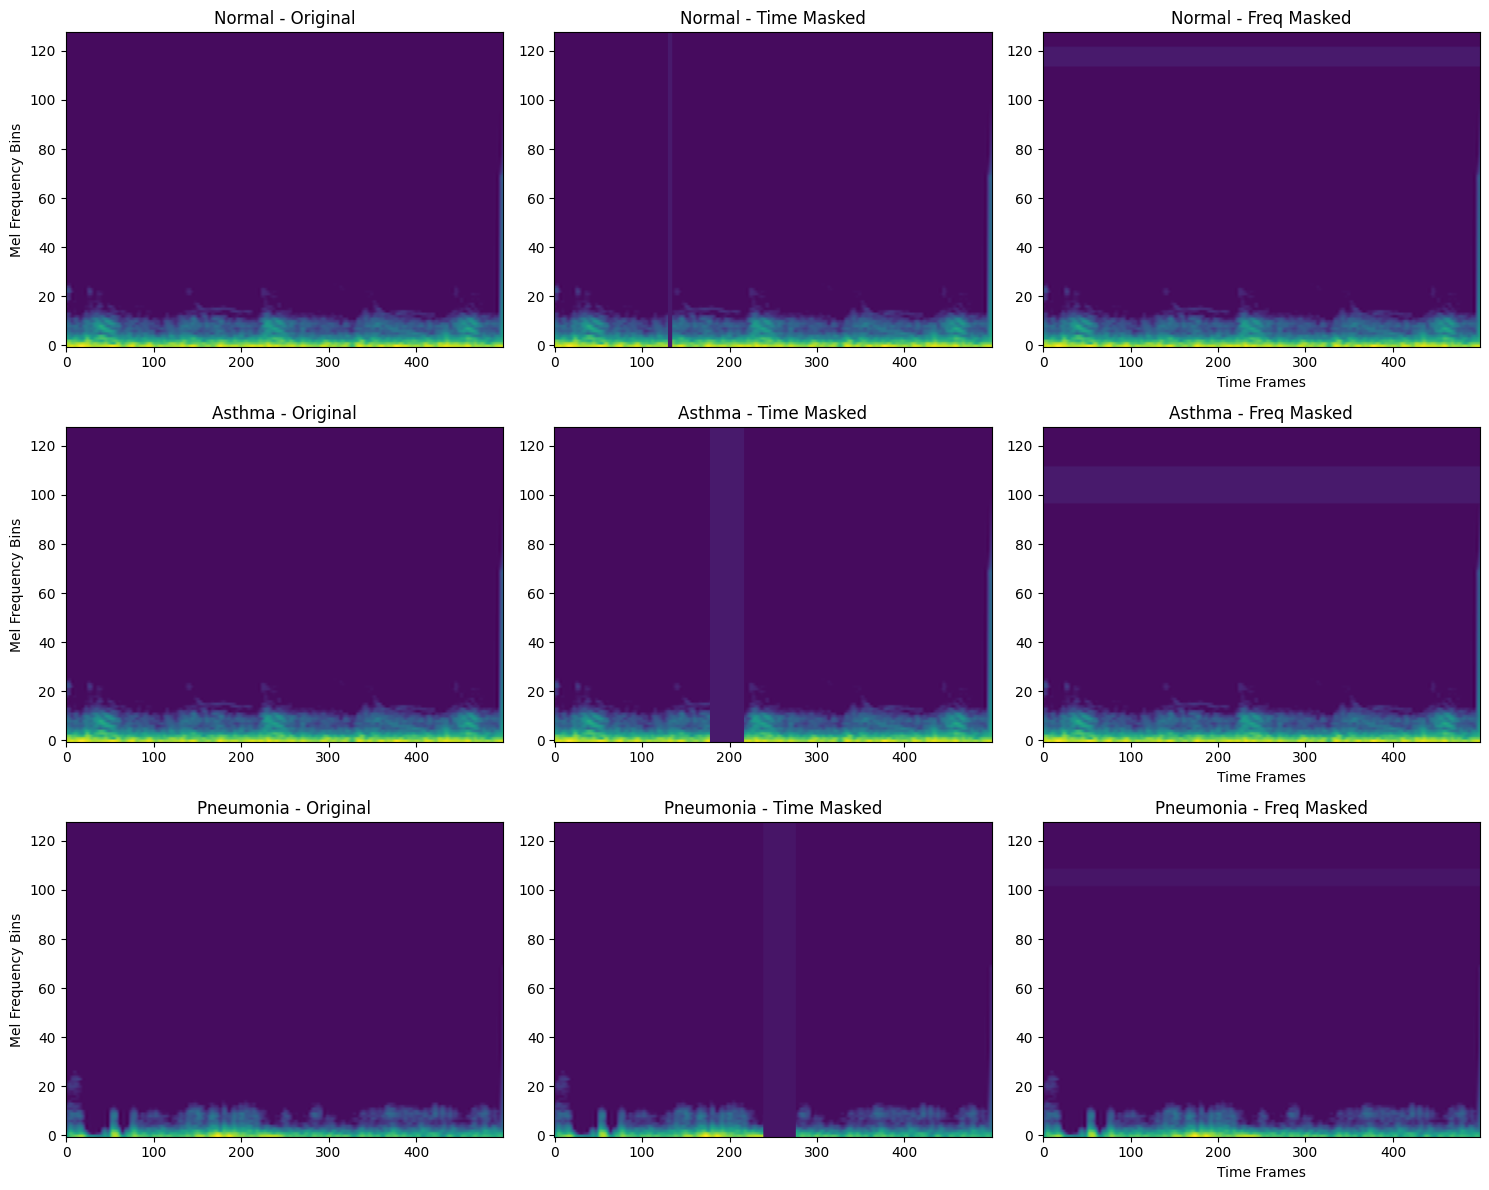

✅ Sample visualizations saved: /content/drive/MyDrive/AST_Respiratory/results/spectrogram_samples.png

🔄 Processing All Audio Segments...
🔄 Processing 108 segments...


Creating spectrograms:   0%|          | 0/108 [00:00<?, ?it/s]

✅ Successfully processed: 108 spectrograms
❌ Failed: 0 segments
📐 Final spectrogram shape: (108, 128, 500)
📐 Labels shape: (108, 10)

💾 Saving Processed Features...
✅ Spectrograms saved: /content/drive/MyDrive/AST_Respiratory/data/processed/spectrograms.npz
✅ Labels saved: /content/drive/MyDrive/AST_Respiratory/data/processed/labels.npy
✅ Metadata saved: /content/drive/MyDrive/AST_Respiratory/data/processed/metadata.json
✅ Parameters saved: /content/drive/MyDrive/AST_Respiratory/data/processed/spectrogram_params.json

📊 Feature Analysis & Verification...
📈 Spectrogram Statistics:
   Shape: (108, 128, 500)
   Mean: 0.0000
   Std: 1.0000
   Min: -0.8197
   Max: 10.7400

🏷️ Label Distribution Verification:
   Normal: 51.0 samples
   Wheeze: 23.0 samples
   Crackle: 34.0 samples
   Rhonchi: 0.0 samples
   Stridor: 0.0 samples
   Pleural: 0.0 samples
   Bronchial: 34.0 samples
   COPD: 0.0 samples
   Asthma: 23.0 samples
   Pneumonia: 34.0 samples

✅ Data Quality Checks:
   Zero spectrogram

In [16]:
# =====================================================================
# AST Step 3: Spectrogram Feature Engineering and Augmentation
# Creates AST-compatible Log Mel Spectrograms with augmentation
# =====================================================================

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from pathlib import Path
import json
import pickle
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

print("🖼️ Step 3: Spectrogram Feature Engineering & Augmentation")
print("=" * 70)

# Load project config and dataset
with open(f"{CONFIG['PROJECT_ROOT']}/config.json", 'r') as f:
    config = json.load(f)

# Load the fixed dataset
dataset_path = Path(config['PROJECT_ROOT']) / 'data' / 'master_dataset_fixed.csv'
df = pd.read_csv(dataset_path)
print(f"✅ Loaded dataset: {len(df)} segments")

# =====================================================================
# 1. AST-COMPATIBLE SPECTROGRAM PARAMETERS
# =====================================================================
print("⚙️ Setting AST-Compatible Parameters...")

# AST standard parameters for optimal performance
SPECTROGRAM_PARAMS = {
    'sample_rate': 16000,        # Standard audio sampling rate
    'n_mels': 128,              # Mel frequency bins (AST standard)
    'n_fft': 2048,              # FFT window size
    'hop_length': 512,          # Hop length for STFT
    'target_length': 500,       # Target time frames (AST compatible)
    'duration': 5.0,            # Segment duration in seconds
    'fmin': 0,                  # Minimum frequency
    'fmax': 8000,               # Maximum frequency (Nyquist/2)
}

# Calculate expected spectrogram dimensions
expected_frames = int(SPECTROGRAM_PARAMS['duration'] * SPECTROGRAM_PARAMS['sample_rate'] / SPECTROGRAM_PARAMS['hop_length'])
print(f"📐 Target Spectrogram Dimensions: {SPECTROGRAM_PARAMS['n_mels']} x {SPECTROGRAM_PARAMS['target_length']}")
print(f"📐 Expected frames from {SPECTROGRAM_PARAMS['duration']}s audio: {expected_frames}")

# =====================================================================
# 2. LOG MEL SPECTROGRAM GENERATION FUNCTION
# =====================================================================
print("\n🎵 Creating Spectrogram Generation Function...")

def create_spectrogram(audio_path, start_time=0, duration=5.0, normalize=True):
    """
    Create AST-compatible Log Mel Spectrogram

    Args:
        audio_path: Path to audio file
        start_time: Start time in seconds
        duration: Duration in seconds
        normalize: Apply Z-score normalization

    Returns:
        spectrogram: (n_mels, target_length) numpy array
    """
    try:
        # Load audio segment
        audio, sr = librosa.load(
            audio_path,
            sr=SPECTROGRAM_PARAMS['sample_rate'],
            offset=start_time,
            duration=duration
        )

        # Ensure minimum length
        min_length = int(SPECTROGRAM_PARAMS['sample_rate'] * duration)
        if len(audio) < min_length:
            # Pad with zeros if too short
            audio = np.pad(audio, (0, min_length - len(audio)), mode='constant')
        elif len(audio) > min_length:
            # Trim if too long
            audio = audio[:min_length]

        # Generate Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=SPECTROGRAM_PARAMS['sample_rate'],
            n_mels=SPECTROGRAM_PARAMS['n_mels'],
            n_fft=SPECTROGRAM_PARAMS['n_fft'],
            hop_length=SPECTROGRAM_PARAMS['hop_length'],
            fmin=SPECTROGRAM_PARAMS['fmin'],
            fmax=SPECTROGRAM_PARAMS['fmax']
        )

        # Convert to Log scale (dB)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Resize to target dimensions
        if log_mel_spec.shape[1] != SPECTROGRAM_PARAMS['target_length']:
            # Use interpolation to resize time dimension
            from scipy.ndimage import zoom
            zoom_factor = SPECTROGRAM_PARAMS['target_length'] / log_mel_spec.shape[1]
            log_mel_spec = zoom(log_mel_spec, (1.0, zoom_factor))

        # Ensure exact target dimensions
        if log_mel_spec.shape[1] > SPECTROGRAM_PARAMS['target_length']:
            log_mel_spec = log_mel_spec[:, :SPECTROGRAM_PARAMS['target_length']]
        elif log_mel_spec.shape[1] < SPECTROGRAM_PARAMS['target_length']:
            pad_width = SPECTROGRAM_PARAMS['target_length'] - log_mel_spec.shape[1]
            log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant')

        # Z-score normalization across entire spectrogram
        if normalize:
            log_mel_spec = (log_mel_spec - np.mean(log_mel_spec)) / (np.std(log_mel_spec) + 1e-8)

        return log_mel_spec

    except Exception as e:
        print(f"⚠️ Error creating spectrogram for {audio_path}: {e}")
        # Return silent spectrogram as fallback
        return np.zeros((SPECTROGRAM_PARAMS['n_mels'], SPECTROGRAM_PARAMS['target_length']))

# =====================================================================
# 3. AUGMENTATION FUNCTIONS
# =====================================================================
print("🔄 Creating Augmentation Functions...")

def time_masking(spectrogram, max_mask_time=40, num_masks=1):
    """
    Apply Time Masking augmentation
    Masks random vertical slices (time steps)
    """
    spec_masked = spectrogram.copy()

    for _ in range(num_masks):
        # Random mask length
        mask_length = np.random.randint(1, max_mask_time + 1)

        # Random start position
        max_start = spec_masked.shape[1] - mask_length
        if max_start > 0:
            start_pos = np.random.randint(0, max_start)
            # Zero out the time slice
            spec_masked[:, start_pos:start_pos + mask_length] = 0

    return spec_masked

def frequency_masking(spectrogram, max_mask_freq=15, num_masks=1):
    """
    Apply Frequency Masking augmentation
    Masks random horizontal slices (frequency bands)
    """
    spec_masked = spectrogram.copy()

    for _ in range(num_masks):
        # Random mask length
        mask_length = np.random.randint(1, max_mask_freq + 1)

        # Random start position
        max_start = spec_masked.shape[0] - mask_length
        if max_start > 0:
            start_pos = np.random.randint(0, max_start)
            # Zero out the frequency band
            spec_masked[start_pos:start_pos + mask_length, :] = 0

    return spec_masked

def apply_augmentation(spectrogram, apply_time_mask=True, apply_freq_mask=True):
    """
    Apply both time and frequency masking
    """
    augmented = spectrogram.copy()

    if apply_time_mask and np.random.random() > 0.5:
        augmented = time_masking(augmented)

    if apply_freq_mask and np.random.random() > 0.5:
        augmented = frequency_masking(augmented)

    return augmented

print("✅ Augmentation functions created")

# =====================================================================
# 4. VISUALIZE SAMPLE SPECTROGRAMS
# =====================================================================
print("\n📊 Creating Sample Visualizations...")

def visualize_spectrograms():
    """Create sample visualizations to verify spectrogram quality"""

    # Get sample from each major class
    sample_classes = ['Normal', 'Asthma', 'Pneumonia']
    fig, axes = plt.subplots(len(sample_classes), 3, figsize=(15, 4 * len(sample_classes)))

    for i, class_name in enumerate(sample_classes):
        # Find sample from this class
        class_samples = df[df['diagnosis'] == class_name]
        if len(class_samples) == 0:
            continue

        sample = class_samples.iloc[0]

        try:
            # Create original spectrogram
            spec_orig = create_spectrogram(
                sample['audio_path'],
                sample['start_time'],
                sample['duration']
            )

            # Create augmented versions
            spec_time_masked = time_masking(spec_orig.copy())
            spec_freq_masked = frequency_masking(spec_orig.copy())

            # Plot original
            axes[i, 0].imshow(spec_orig, aspect='auto', origin='lower', cmap='viridis')
            axes[i, 0].set_title(f'{class_name} - Original')
            axes[i, 0].set_ylabel('Mel Frequency Bins')

            # Plot time masked
            axes[i, 1].imshow(spec_time_masked, aspect='auto', origin='lower', cmap='viridis')
            axes[i, 1].set_title(f'{class_name} - Time Masked')

            # Plot frequency masked
            axes[i, 2].imshow(spec_freq_masked, aspect='auto', origin='lower', cmap='viridis')
            axes[i, 2].set_title(f'{class_name} - Freq Masked')
            axes[i, 2].set_xlabel('Time Frames')

        except Exception as e:
            print(f"⚠️ Error visualizing {class_name}: {e}")

    plt.tight_layout()

    # Save visualization
    viz_path = Path(config['PROJECT_ROOT']) / 'results' / 'spectrogram_samples.png'
    viz_path.parent.mkdir(exist_ok=True)
    plt.savefig(viz_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Sample visualizations saved: {viz_path}")

# Create sample visualizations
visualize_spectrograms()

# =====================================================================
# 5. PROCESS ALL SEGMENTS
# =====================================================================
print("\n🔄 Processing All Audio Segments...")

def process_all_segments():
    """Process all segments to create spectrograms"""

    # Prepare storage
    spectrograms = []
    labels = []
    metadata = []
    failed_count = 0

    print(f"🔄 Processing {len(df)} segments...")

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Creating spectrograms"):
        try:
            # Create spectrogram
            spectrogram = create_spectrogram(
                row['audio_path'],
                row['start_time'],
                row['duration']
            )

            # Verify dimensions
            expected_shape = (SPECTROGRAM_PARAMS['n_mels'], SPECTROGRAM_PARAMS['target_length'])
            if spectrogram.shape != expected_shape:
                print(f"⚠️ Unexpected shape {spectrogram.shape} for segment {idx}")
                continue

            # Store results
            spectrograms.append(spectrogram)
            labels.append(eval(row['multi_label_vector']))  # Convert string back to list

            # Store metadata
            metadata.append({
                'segment_id': row['segment_id'],
                'patient_id': row['patient_id'],
                'source_dataset': row['source_dataset'],
                'diagnosis': row['diagnosis'],
                'label_names': eval(row['label_names']) if isinstance(row['label_names'], str) else row['label_names']
            })

        except Exception as e:
            failed_count += 1
            if failed_count < 5:  # Show first few errors
                print(f"⚠️ Failed to process segment {idx}: {e}")

    # Convert to numpy arrays
    spectrograms = np.array(spectrograms)
    labels = np.array(labels)

    print(f"✅ Successfully processed: {len(spectrograms)} spectrograms")
    print(f"❌ Failed: {failed_count} segments")
    print(f"📐 Final spectrogram shape: {spectrograms.shape}")
    print(f"📐 Labels shape: {labels.shape}")

    return spectrograms, labels, metadata

# Process all segments
spectrograms, labels, metadata = process_all_segments()

# =====================================================================
# 6. SAVE PROCESSED FEATURES
# =====================================================================
print("\n💾 Saving Processed Features...")

# Create features directory
features_dir = Path(config['PROJECT_ROOT']) / 'data' / 'processed'
features_dir.mkdir(exist_ok=True)

# Save spectrograms (compressed)
spectrograms_path = features_dir / 'spectrograms.npz'
np.savez_compressed(spectrograms_path, spectrograms=spectrograms)
print(f"✅ Spectrograms saved: {spectrograms_path}")

# Save labels
labels_path = features_dir / 'labels.npy'
np.save(labels_path, labels)
print(f"✅ Labels saved: {labels_path}")

# Save metadata
metadata_path = features_dir / 'metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved: {metadata_path}")

# Save processing parameters
params_path = features_dir / 'spectrogram_params.json'
with open(params_path, 'w') as f:
    json.dump(SPECTROGRAM_PARAMS, f, indent=2)
print(f"✅ Parameters saved: {params_path}")

# =====================================================================
# 7. FEATURE ANALYSIS & VERIFICATION
# =====================================================================
print("\n📊 Feature Analysis & Verification...")

# Basic statistics
print(f"📈 Spectrogram Statistics:")
print(f"   Shape: {spectrograms.shape}")
print(f"   Mean: {np.mean(spectrograms):.4f}")
print(f"   Std: {np.std(spectrograms):.4f}")
print(f"   Min: {np.min(spectrograms):.4f}")
print(f"   Max: {np.max(spectrograms):.4f}")

# Label distribution verification
print(f"\n🏷️ Label Distribution Verification:")
class_names = ['Normal', 'Wheeze', 'Crackle', 'Rhonchi', 'Stridor', 'Pleural', 'Bronchial', 'COPD', 'Asthma', 'Pneumonia']
for i, class_name in enumerate(class_names):
    count = np.sum(labels[:, i])
    print(f"   {class_name}: {count} samples")

# Data quality checks
print(f"\n✅ Data Quality Checks:")
print(f"   Zero spectrograms: {np.sum(np.all(spectrograms == 0, axis=(1,2)))}")
print(f"   NaN values: {np.sum(np.isnan(spectrograms))}")
print(f"   Infinite values: {np.sum(np.isinf(spectrograms))}")

# Memory usage
memory_mb = spectrograms.nbytes / (1024 * 1024)
print(f"   Memory usage: {memory_mb:.2f} MB")

# =====================================================================
# 8. UPDATE CONFIG AND SUMMARY
# =====================================================================
print("\n🎉 Step 3 Complete!")
print("=" * 70)

# Update global config
config['SPECTROGRAMS_PATH'] = str(spectrograms_path)
config['LABELS_PATH'] = str(labels_path)
config['METADATA_PATH'] = str(metadata_path)
config['SPECTROGRAM_PARAMS'] = SPECTROGRAM_PARAMS
config['NUM_SAMPLES'] = len(spectrograms)

# Save updated config
with open(f"{CONFIG['PROJECT_ROOT']}/config.json", 'w') as f:
    json.dump(config, f, indent=2)

# Update global CONFIG
CONFIG.update(config)

print("✅ AST-Compatible Spectrograms Created")
print("✅ Data Augmentation Functions Ready")
print("✅ Z-Score Normalization Applied")
print(f"✅ {len(spectrograms)} spectrograms ready for training")
print(f"✅ Target dimensions: {SPECTROGRAM_PARAMS['n_mels']}x{SPECTROGRAM_PARAMS['target_length']}")
print("✅ All features saved and verified")

print(f"\n📁 Features saved to: {features_dir}")
print("🚀 Ready for Step 4: Data Splitting & Class Weighting!")
print("=" * 70)

✂️ Step 4: Data Splitting, Class Weighting & TensorFlow Pipeline
📥 Loading Processed Features...
✅ Loaded: 108 spectrograms, 108 labels, 108 metadata
📐 Spectrogram shape: (108, 128, 500)
📐 Labels shape: (108, 10)

👥 Creating Patient-Independent Data Splits...
📊 Total patients: 40
📊 Total segments: 108
📊 Patient splits: Train=28, Val=6, Test=6
📊 Segment splits: Train=79, Val=16, Test=13
✅ Patient independence verified - no overlaps!

📊 Final Data Splits:
   Train: 79 samples (73.1%)
   Validation: 16 samples (14.8%)
   Test: 13 samples (12.0%)

⚖️ Calculating Class Weights for Imbalanced Multi-Label Data...
📊 Training Set Class Distribution & Weights:
   Normal: 36.0 samples, weight: 1.097
   Wheeze: 17.0 samples, weight: 2.324
   Crackle: 26.0 samples, weight: 1.519
   Rhonchi: 0.0 samples, weight: 1.000
   Stridor: 0.0 samples, weight: 1.000
   Pleural: 0.0 samples, weight: 1.000
   Bronchial: 26.0 samples, weight: 1.519
   COPD: 0.0 samples, weight: 1.000
   Asthma: 17.0 samples, wei

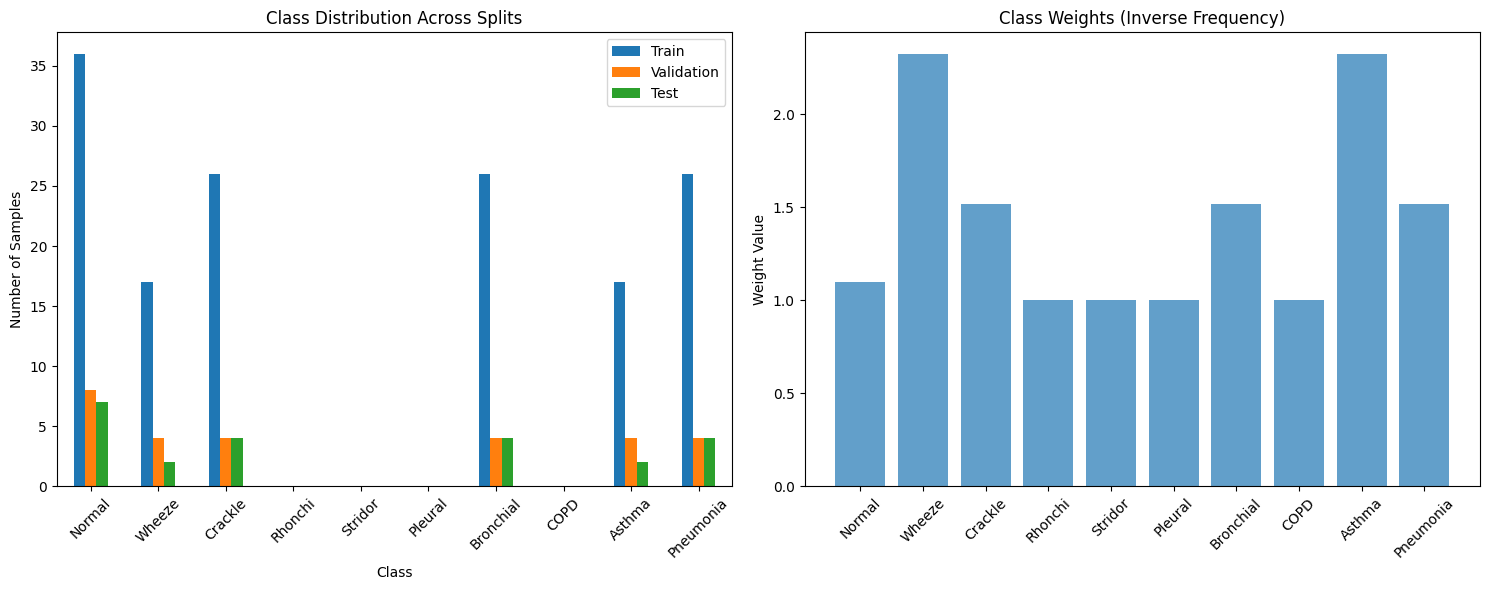

✅ Class distribution plot saved: /content/drive/MyDrive/AST_Respiratory/results/class_distribution.png

📊 Class Distribution Summary:
    Class  Train  Validation  Test
   Normal   36.0         8.0   7.0
   Wheeze   17.0         4.0   2.0
  Crackle   26.0         4.0   4.0
  Rhonchi    0.0         0.0   0.0
  Stridor    0.0         0.0   0.0
  Pleural    0.0         0.0   0.0
Bronchial   26.0         4.0   4.0
     COPD    0.0         0.0   0.0
   Asthma   17.0         4.0   2.0
Pneumonia   26.0         4.0   4.0

💾 Saving Dataset Splits and Configuration...
✅ Data splits saved: /content/drive/MyDrive/AST_Respiratory/data/processed/data_splits.npz
✅ Class weights saved: /content/drive/MyDrive/AST_Respiratory/data/processed/class_weights.json
✅ Pipeline config saved: /content/drive/MyDrive/AST_Respiratory/data/processed/pipeline_config.json

🔧 Updating Global Configuration...
✅ Global configuration updated
✅ Datasets available as: train_dataset, val_dataset, test_dataset
✅ Class weights

In [17]:
# =====================================================================
# AST Step 4: Data Splitting, Class Weighting & TensorFlow Pipeline
# CRITICAL: Patient-independent splits + class balancing
# =====================================================================

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import json
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

print("✂️ Step 4: Data Splitting, Class Weighting & TensorFlow Pipeline")
print("=" * 75)

# =====================================================================
# 1. LOAD PROCESSED DATA
# =====================================================================
print("📥 Loading Processed Features...")

# Load spectrograms
spectrograms_path = Path(CONFIG['PROJECT_ROOT']) / 'data' / 'processed' / 'spectrograms.npz'
spectrograms_data = np.load(spectrograms_path)
spectrograms = spectrograms_data['spectrograms']

# Load labels
labels_path = Path(CONFIG['PROJECT_ROOT']) / 'data' / 'processed' / 'labels.npy'
labels = np.load(labels_path)

# Load metadata
metadata_path = Path(CONFIG['PROJECT_ROOT']) / 'data' / 'processed' / 'metadata.json'
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"✅ Loaded: {len(spectrograms)} spectrograms, {len(labels)} labels, {len(metadata)} metadata")
print(f"📐 Spectrogram shape: {spectrograms.shape}")
print(f"📐 Labels shape: {labels.shape}")

# =====================================================================
# 2. PATIENT-INDEPENDENT DATA SPLITTING
# =====================================================================
print("\n👥 Creating Patient-Independent Data Splits...")

def create_patient_independent_splits():
    """
    Create train/val/test splits ensuring no patient appears in multiple sets
    Split ratio: 70% train, 15% validation, 15% test
    """

    # Extract patient IDs
    patient_ids = [meta['patient_id'] for meta in metadata]
    unique_patients = list(set(patient_ids))

    print(f"📊 Total patients: {len(unique_patients)}")
    print(f"📊 Total segments: {len(patient_ids)}")

    # Split patients first
    patients_train, patients_temp = train_test_split(
        unique_patients,
        test_size=0.3,  # 30% for val+test
        random_state=42,
        shuffle=True
    )

    # Split temp into val and test (15% each)
    patients_val, patients_test = train_test_split(
        patients_temp,
        test_size=0.5,  # 50% of 30% = 15% each
        random_state=42,
        shuffle=True
    )

    print(f"📊 Patient splits: Train={len(patients_train)}, Val={len(patients_val)}, Test={len(patients_test)}")

    # Map segments to splits based on patient assignment
    train_indices = []
    val_indices = []
    test_indices = []

    for i, patient_id in enumerate(patient_ids):
        if patient_id in patients_train:
            train_indices.append(i)
        elif patient_id in patients_val:
            val_indices.append(i)
        elif patient_id in patients_test:
            test_indices.append(i)

    print(f"📊 Segment splits: Train={len(train_indices)}, Val={len(val_indices)}, Test={len(test_indices)}")

    # Verify no patient overlap
    train_patients = set([patient_ids[i] for i in train_indices])
    val_patients = set([patient_ids[i] for i in val_indices])
    test_patients = set([patient_ids[i] for i in test_indices])

    assert len(train_patients & val_patients) == 0, "Patient overlap between train and validation!"
    assert len(train_patients & test_patients) == 0, "Patient overlap between train and test!"
    assert len(val_patients & test_patients) == 0, "Patient overlap between validation and test!"

    print("✅ Patient independence verified - no overlaps!")

    return train_indices, val_indices, test_indices

# Create splits
train_idx, val_idx, test_idx = create_patient_independent_splits()

# Split the data
X_train = spectrograms[train_idx]
y_train = labels[train_idx]
train_metadata = [metadata[i] for i in train_idx]

X_val = spectrograms[val_idx]
y_val = labels[val_idx]
val_metadata = [metadata[i] for i in val_idx]

X_test = spectrograms[test_idx]
y_test = labels[test_idx]
test_metadata = [metadata[i] for i in test_idx]

print(f"\n📊 Final Data Splits:")
print(f"   Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(spectrograms)*100:.1f}%)")
print(f"   Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(spectrograms)*100:.1f}%)")
print(f"   Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(spectrograms)*100:.1f}%)")

# =====================================================================
# 3. CLASS WEIGHT CALCULATION
# =====================================================================
print("\n⚖️ Calculating Class Weights for Imbalanced Multi-Label Data...")

def calculate_multilabel_class_weights(y_train):
    """
    Calculate class weights for multi-label imbalanced dataset
    Uses inverse frequency weighting for each class independently
    """

    class_names = ['Normal', 'Wheeze', 'Crackle', 'Rhonchi', 'Stridor',
                   'Pleural', 'Bronchial', 'COPD', 'Asthma', 'Pneumonia']

    class_weights = {}
    class_frequencies = {}

    print("📊 Training Set Class Distribution & Weights:")

    for i, class_name in enumerate(class_names):
        # Count positive samples for this class
        positive_samples = np.sum(y_train[:, i])
        negative_samples = len(y_train) - positive_samples

        # Calculate inverse frequency weight
        if positive_samples > 0:
            # Standard formula: n_samples / (n_classes * class_count)
            weight = len(y_train) / (2 * positive_samples)
        else:
            # Handle case where class has no positive samples
            weight = 1.0

        class_weights[i] = weight
        class_frequencies[class_name] = {
            'positive': int(positive_samples),
            'negative': int(negative_samples),
            'weight': weight
        }

        print(f"   {class_name}: {positive_samples} samples, weight: {weight:.3f}")

    return class_weights, class_frequencies

# Calculate class weights
class_weights, class_frequencies = calculate_multilabel_class_weights(y_train)

# =====================================================================
# 4. AUGMENTATION FUNCTIONS FOR TENSORFLOW
# =====================================================================
print("\n🔄 Creating TensorFlow-Compatible Augmentation...")

def tf_time_masking(spectrogram, max_mask_time=40):
    """TensorFlow-compatible time masking"""

    def apply_mask(spec):
        # Random mask parameters
        mask_length = tf.random.uniform([], 1, max_mask_time, dtype=tf.int32)
        time_steps = tf.shape(spec)[1]
        start_pos = tf.random.uniform([], 0, tf.maximum(1, time_steps - mask_length), dtype=tf.int32)

        # Create mask
        mask = tf.ones_like(spec)
        indices = tf.range(tf.shape(spec)[1])
        mask_condition = (indices >= start_pos) & (indices < start_pos + mask_length)
        mask = tf.where(mask_condition[None, :], 0.0, mask)

        return spec * mask

    # Apply with 50% probability
    return tf.cond(
        tf.random.uniform([]) > 0.5,
        lambda: apply_mask(spectrogram),
        lambda: spectrogram
    )

def tf_frequency_masking(spectrogram, max_mask_freq=15):
    """TensorFlow-compatible frequency masking"""

    def apply_mask(spec):
        # Random mask parameters
        mask_length = tf.random.uniform([], 1, max_mask_freq, dtype=tf.int32)
        freq_bins = tf.shape(spec)[0]
        start_pos = tf.random.uniform([], 0, tf.maximum(1, freq_bins - mask_length), dtype=tf.int32)

        # Create mask
        mask = tf.ones_like(spec)
        indices = tf.range(tf.shape(spec)[0])
        mask_condition = (indices >= start_pos) & (indices < start_pos + mask_length)
        mask = tf.where(mask_condition[:, None], 0.0, mask)

        return spec * mask

    # Apply with 50% probability
    return tf.cond(
        tf.random.uniform([]) > 0.5,
        lambda: apply_mask(spectrogram),
        lambda: spectrogram
    )

def augment_spectrogram(spectrogram, label):
    """Apply both augmentations"""
    # Apply time masking
    spectrogram = tf_time_masking(spectrogram)
    # Apply frequency masking
    spectrogram = tf_frequency_masking(spectrogram)
    return spectrogram, label

# =====================================================================
# 5. TENSORFLOW DATASET CREATION
# =====================================================================
print("\n🚀 Creating Optimized TensorFlow Datasets...")

def create_tf_dataset(X, y, batch_size=32, shuffle=True, augment=False, cache=True):
    """
    Create optimized tf.data.Dataset with proper preprocessing
    """

    # Create dataset from numpy arrays
    dataset = tf.data.Dataset.from_tensor_slices((X.astype(np.float32), y.astype(np.float32)))

    # Cache for performance (before augmentation)
    if cache:
        dataset = dataset.cache()

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))

    # Apply augmentation (only for training)
    if augment:
        dataset = dataset.map(augment_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch the data
    dataset = dataset.batch(batch_size)

    # Prefetch for performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Configuration
BATCH_SIZE = 32

print(f"🔧 Creating datasets with batch size: {BATCH_SIZE}")

# Create training dataset (with augmentation)
train_dataset = create_tf_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,  # Enable augmentation for training
    cache=True
)

# Create validation dataset (no augmentation)
val_dataset = create_tf_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,  # No augmentation for validation
    cache=True
)

# Create test dataset (no augmentation)
test_dataset = create_tf_dataset(
    X_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,  # No augmentation for test
    cache=True
)

print("✅ TensorFlow datasets created successfully!")

# =====================================================================
# 6. DATASET VERIFICATION
# =====================================================================
print("\n🔍 Verifying Dataset Pipeline...")

def verify_datasets():
    """Verify the dataset pipeline works correctly"""

    print("🔍 Dataset Pipeline Verification:")

    # Check batch shapes
    for batch_x, batch_y in train_dataset.take(1):
        print(f"   Training batch shape: X={batch_x.shape}, y={batch_y.shape}")

    for batch_x, batch_y in val_dataset.take(1):
        print(f"   Validation batch shape: X={batch_x.shape}, y={batch_y.shape}")

    # Verify augmentation is working (training should have some variation)
    print("\n🔄 Augmentation Verification:")
    sample_spec = X_train[0:1]  # Take first sample

    # Create dataset with augmentation
    aug_dataset = tf.data.Dataset.from_tensor_slices((sample_spec, y_train[0:1]))
    aug_dataset = aug_dataset.map(augment_spectrogram)

    original_mean = np.mean(sample_spec)

    aug_means = []
    for spec, _ in aug_dataset.take(5):  # Take 5 augmented versions
        aug_means.append(float(tf.reduce_mean(spec)))

    print(f"   Original mean: {original_mean:.4f}")
    print(f"   Augmented means: {[f'{m:.4f}' for m in aug_means]}")
    print(f"   Variation detected: {'✅' if len(set([f'{m:.3f}' for m in aug_means])) > 1 else '❌'}")

verify_datasets()

# =====================================================================
# 7. VISUALIZE CLASS DISTRIBUTION
# =====================================================================
print("\n📊 Visualizing Class Distribution Across Splits...")

def plot_class_distribution():
    """Plot class distribution across train/val/test splits"""

    class_names = ['Normal', 'Wheeze', 'Crackle', 'Rhonchi', 'Stridor',
                   'Pleural', 'Bronchial', 'COPD', 'Asthma', 'Pneumonia']

    # Calculate distributions
    train_counts = np.sum(y_train, axis=0)
    val_counts = np.sum(y_val, axis=0)
    test_counts = np.sum(y_test, axis=0)

    # Create comparison dataframe
    dist_df = pd.DataFrame({
        'Class': class_names,
        'Train': train_counts,
        'Validation': val_counts,
        'Test': test_counts
    })

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Stacked bar chart
    dist_df.set_index('Class')[['Train', 'Validation', 'Test']].plot(
        kind='bar', ax=ax1, title='Class Distribution Across Splits'
    )
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()

    # Class weights visualization
    weights_df = pd.DataFrame({
        'Class': class_names,
        'Weight': [class_weights[i] for i in range(len(class_names))],
        'Count': train_counts
    })

    ax2.bar(weights_df['Class'], weights_df['Weight'], alpha=0.7)
    ax2.set_title('Class Weights (Inverse Frequency)')
    ax2.set_ylabel('Weight Value')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()

    # Save plot
    plot_path = Path(CONFIG['PROJECT_ROOT']) / 'results' / 'class_distribution.png'
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Class distribution plot saved: {plot_path}")

    return dist_df

# Create visualization
distribution_df = plot_class_distribution()
print("\n📊 Class Distribution Summary:")
print(distribution_df.to_string(index=False))

# =====================================================================
# 8. SAVE DATASET SPLITS AND CONFIGURATION
# =====================================================================
print("\n💾 Saving Dataset Splits and Configuration...")

# Save split indices
splits_path = Path(CONFIG['PROJECT_ROOT']) / 'data' / 'processed' / 'data_splits.npz'
np.savez_compressed(
    splits_path,
    train_indices=train_idx,
    val_indices=val_idx,
    test_indices=test_idx
)

# Save class weights
weights_path = Path(CONFIG['PROJECT_ROOT']) / 'data' / 'processed' / 'class_weights.json'
with open(weights_path, 'w') as f:
    json.dump({
        'class_weights': class_weights,
        'class_frequencies': class_frequencies
    }, f, indent=2)

# Save pipeline configuration
pipeline_config = {
    'batch_size': BATCH_SIZE,
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'augmentation_enabled': True,
    'cache_enabled': True,
    'class_weights': class_weights
}

pipeline_path = Path(CONFIG['PROJECT_ROOT']) / 'data' / 'processed' / 'pipeline_config.json'
with open(pipeline_path, 'w') as f:
    json.dump(pipeline_config, f, indent=2)

print(f"✅ Data splits saved: {splits_path}")
print(f"✅ Class weights saved: {weights_path}")
print(f"✅ Pipeline config saved: {pipeline_path}")

# =====================================================================
# 9. UPDATE GLOBAL CONFIG
# =====================================================================
print("\n🔧 Updating Global Configuration...")

# Update CONFIG with new paths and settings
CONFIG.update({
    'TRAIN_DATASET': 'train_dataset',  # TF dataset objects can't be serialized
    'VAL_DATASET': 'val_dataset',
    'TEST_DATASET': 'test_dataset',
    'BATCH_SIZE': BATCH_SIZE,
    'CLASS_WEIGHTS': class_weights,
    'TRAIN_SAMPLES': len(X_train),
    'VAL_SAMPLES': len(X_val),
    'TEST_SAMPLES': len(X_test),
    'SPLITS_PATH': str(splits_path),
    'WEIGHTS_PATH': str(weights_path),
    'PIPELINE_CONFIG_PATH': str(pipeline_path)
})

# Make datasets available globally
globals()['train_dataset'] = train_dataset
globals()['val_dataset'] = val_dataset
globals()['test_dataset'] = test_dataset
globals()['class_weights'] = class_weights

print("✅ Global configuration updated")
print("✅ Datasets available as: train_dataset, val_dataset, test_dataset")
print("✅ Class weights available as: class_weights")

# =====================================================================
# 10. FINAL SUMMARY
# =====================================================================
print("\n🎉 Step 4 Complete!")
print("=" * 75)
print("✅ Patient-independent data splits created (70/15/15)")
print("✅ Class weights calculated for imbalanced multi-label data")
print("✅ TensorFlow datasets with augmentation pipeline ready")
print("✅ Optimized data loading with caching and prefetching")
print("✅ Augmentation verified and working")
print("✅ All configurations saved for reproducibility")

print(f"\n📊 Ready for Training:")
print(f"   🚂 Training: {len(X_train)} samples, {len(train_dataset)} batches")
print(f"   🔍 Validation: {len(X_val)} samples, {len(val_dataset)} batches")
print(f"   🧪 Test: {len(X_test)} samples, {len(test_dataset)} batches")
print(f"   ⚖️ Class weights: {len([w for w in class_weights.values() if w > 1])} imbalanced classes")

print("\n🚀 Ready for Step 5: AST Model Architecture!")
print("=" * 75)

In [19]:
# =====================================================================
# AST Step 5: Audio Spectrogram Transformer (AST) Model Architecture
# Builds complete AST model for multi-label respiratory classification
# =====================================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

print("🤖 Step 5: Audio Spectrogram Transformer (AST) Model Architecture")
print("=" * 80)

# =====================================================================
# 1. AST MODEL CONFIGURATION
# =====================================================================
print("⚙️ Configuring AST Model Parameters...")

# AST Architecture Parameters (optimized for 128x500 spectrograms)
AST_CONFIG = {
    # Input specifications
    'input_shape': (128, 500, 1),  # Height, Width, Channels
    'num_classes': 10,             # Multi-label classes

    # Patch embedding
    'patch_size': 16,              # 16x16 patches (standard for AST)
    'embed_dim': 768,              # Embedding dimension (AST-Base standard)

    # Transformer architecture
    'num_heads': 12,               # Multi-head attention heads
    'num_layers': 12,              # Transformer encoder layers
    'mlp_dim': 3072,              # Feed-forward network dimension (4x embed_dim)
    'dropout_rate': 0.1,           # Dropout for regularization

    # Training parameters
    'learning_rate': 1e-4,         # Adam learning rate
    'weight_decay': 1e-4,          # L2 regularization

    # Output configuration
    'activation': 'sigmoid',       # Multi-label classification
    'loss': 'binary_crossentropy'  # Multi-label loss
}

# Calculate patch dimensions
height_patches = AST_CONFIG['input_shape'][0] // AST_CONFIG['patch_size']  # 128/16 = 8
width_patches = AST_CONFIG['input_shape'][1] // AST_CONFIG['patch_size']   # 500/16 = 31.25 → 31
num_patches = height_patches * width_patches

print(f"📐 Input shape: {AST_CONFIG['input_shape']}")
print(f"📐 Patch size: {AST_CONFIG['patch_size']}x{AST_CONFIG['patch_size']}")
print(f"📐 Number of patches: {height_patches} x {width_patches} = {num_patches}")
print(f"📐 Embedding dimension: {AST_CONFIG['embed_dim']}")

# =====================================================================
# 2. PATCH EMBEDDING LAYER
# =====================================================================
print("\n🔲 Creating Patch Embedding Layer...")

class PatchEmbedding(layers.Layer):
    """
    Converts 2D spectrogram into sequence of patch embeddings
    Similar to ViT patch embedding but optimized for spectrograms
    """

    def __init__(self, patch_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        # Convolutional layer to extract patches and embed them
        self.projection = layers.Conv2D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding='valid',
            name='patch_projection'
        )

    def call(self, images):
        # Extract patches and flatten
        patches = self.projection(images)  # (batch, H/P, W/P, embed_dim)
        batch_size = tf.shape(patches)[0]

        # Reshape to sequence format
        patches = tf.reshape(patches, [batch_size, -1, self.embed_dim])  # (batch, num_patches, embed_dim)

        return patches

    def get_config(self):
        config = super().get_config()
        config.update({
            'patch_size': self.patch_size,
            'embed_dim': self.embed_dim
        })
        return config

# =====================================================================
# 3. POSITIONAL ENCODING
# =====================================================================
print("📍 Creating Positional Encoding...")

class PositionalEncoding(layers.Layer):
    """
    Adds learnable positional embeddings to patch embeddings
    """

    def __init__(self, num_patches, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim = embed_dim

        # Learnable positional embeddings
        self.position_embedding = layers.Embedding(
            input_dim=num_patches,
            output_dim=embed_dim,
            name='position_embedding'
        )

    def call(self, encoded_patches):
        batch_size = tf.shape(encoded_patches)[0]

        # Create position indices
        positions = tf.range(start=0, limit=self.num_patches, delta=1)

        # Get positional encodings
        position_embeddings = self.position_embedding(positions)

        # Add positional encoding to patches
        encoded_patches = encoded_patches + position_embeddings

        return encoded_patches

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_patches': self.num_patches,
            'embed_dim': self.embed_dim
        })
        return config

# =====================================================================
# 4. TRANSFORMER ENCODER BLOCK
# =====================================================================
print("🔄 Creating Transformer Encoder Block...")

class TransformerEncoderBlock(layers.Layer):
    """
    Single transformer encoder block with multi-head attention and MLP
    """

    def __init__(self, embed_dim, num_heads, mlp_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout_rate = dropout_rate

        # Multi-head self-attention
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=dropout_rate,
            name='multi_head_attention'
        )

        # Layer normalization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6, name='layernorm1')
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6, name='layernorm2')

        # MLP (Feed-forward network)
        self.mlp = keras.Sequential([
            layers.Dense(mlp_dim, activation='gelu', name='mlp_dense1'),
            layers.Dropout(dropout_rate, name='mlp_dropout'),
            layers.Dense(embed_dim, name='mlp_dense2')
        ], name='mlp')

        # Dropout
        self.dropout1 = layers.Dropout(dropout_rate, name='dropout1')
        self.dropout2 = layers.Dropout(dropout_rate, name='dropout2')

    def call(self, inputs, training=None):
        # Multi-head self-attention with residual connection
        attention_output = self.attention(inputs, inputs, training=training)
        attention_output = self.dropout1(attention_output, training=training)
        x1 = self.layernorm1(inputs + attention_output)

        # MLP with residual connection
        mlp_output = self.mlp(x1, training=training)
        mlp_output = self.dropout2(mlp_output, training=training)
        x2 = self.layernorm2(x1 + mlp_output)

        return x2

    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'mlp_dim': self.mlp_dim,
            'dropout_rate': self.dropout_rate
        })
        return config

# =====================================================================
# 5. COMPLETE AST MODEL ARCHITECTURE
# =====================================================================
print("\n🏗️ Building Complete AST Model...")

def create_ast_model(config):
    """
    Create complete Audio Spectrogram Transformer model
    """

    # Calculate number of patches statically
    height_patches = config['input_shape'][0] // config['patch_size']  # 128/16 = 8
    width_patches = config['input_shape'][1] // config['patch_size']   # 500/16 = 31
    num_patches_calculated = height_patches * width_patches

    # Input layer
    inputs = layers.Input(shape=config['input_shape'], name='spectrogram_input')

    # Patch embedding
    patches = PatchEmbedding(
        patch_size=config['patch_size'],
        embed_dim=config['embed_dim'],
        name='patch_embedding'
    )(inputs)

    # Positional encoding (use statically calculated num_patches)
    encoded_patches = PositionalEncoding(
        num_patches=num_patches_calculated,
        embed_dim=config['embed_dim'],
        name='positional_encoding'
    )(patches)

    # Dropout after embeddings
    x = layers.Dropout(config['dropout_rate'], name='embedding_dropout')(encoded_patches)

    # Stack of Transformer encoder blocks
    for i in range(config['num_layers']):
        x = TransformerEncoderBlock(
            embed_dim=config['embed_dim'],
            num_heads=config['num_heads'],
            mlp_dim=config['mlp_dim'],
            dropout_rate=config['dropout_rate'],
            name=f'transformer_block_{i}'
        )(x)

    # Global average pooling
    x = layers.GlobalAveragePooling1D(name='global_avg_pooling')(x)

    # Layer normalization before classification
    x = layers.LayerNormalization(epsilon=1e-6, name='final_layernorm')(x)

    # Classification head
    x = layers.Dropout(config['dropout_rate'], name='classifier_dropout')(x)
    outputs = layers.Dense(
        config['num_classes'],
        activation=config['activation'],
        name='classification_head'
    )(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs, name='AST_Respiratory_Classifier')

    return model

# Create the AST model
print("🔨 Instantiating AST model...")
ast_model = create_ast_model(AST_CONFIG)

print("✅ AST model created successfully!")

# =====================================================================
# 6. MODEL COMPILATION
# =====================================================================
print("\n⚙️ Compiling AST Model...")

# Custom metrics for multi-label classification
def macro_f1_score(y_true, y_pred):
    """Calculate macro F1 score for multi-label classification"""

    # Convert predictions to binary
    y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)

    # Calculate F1 for each class
    def f1_class(i):
        y_true_class = y_true[:, i]
        y_pred_class = y_pred_binary[:, i]

        tp = tf.reduce_sum(y_true_class * y_pred_class)
        fp = tf.reduce_sum((1 - y_true_class) * y_pred_class)
        fn = tf.reduce_sum(y_true_class * (1 - y_pred_class))

        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())

        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    # Calculate F1 for all classes
    f1_scores = tf.stack([f1_class(i) for i in range(AST_CONFIG['num_classes'])])

    # Return macro average
    return tf.reduce_mean(f1_scores)

# Compile the model
ast_model.compile(
    optimizer=optimizers.Adam(
        learning_rate=AST_CONFIG['learning_rate'],
        weight_decay=AST_CONFIG['weight_decay']
    ),
    loss=AST_CONFIG['loss'],
    metrics=[
        'accuracy',
        metrics.AUC(name='auc', multi_label=True),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        macro_f1_score
    ]
)

print("✅ Model compiled with:")
print(f"   📈 Optimizer: Adam (lr={AST_CONFIG['learning_rate']}, wd={AST_CONFIG['weight_decay']})")
print(f"   📊 Loss: {AST_CONFIG['loss']}")
print("   📋 Metrics: Accuracy, AUC, Precision, Recall, Macro-F1")

# =====================================================================
# 7. MODEL SUMMARY AND ANALYSIS
# =====================================================================
print("\n📊 Model Architecture Summary...")

# Display model summary
ast_model.summary()

# Calculate model parameters
total_params = ast_model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in ast_model.trainable_weights])

print(f"\n📈 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size (MB): {total_params * 4 / (1024**2):.2f}")

# =====================================================================
# 8. MODEL VISUALIZATION
# =====================================================================
print("\n🎨 Creating Model Architecture Visualization...")

def visualize_model():
    """Create and save model architecture diagram"""

    try:
        # Create model plot
        plot_path = Path(CONFIG['PROJECT_ROOT']) / 'results' / 'ast_model_architecture.png'

        keras.utils.plot_model(
            ast_model,
            to_file=plot_path,
            show_shapes=True,
            show_dtype=True,
            show_layer_names=True,
            rankdir='TB',
            expand_nested=True,
            dpi=150
        )

        print(f"✅ Model architecture diagram saved: {plot_path}")

    except Exception as e:
        print(f"⚠️ Could not create model diagram: {e}")
        print("💡 Install graphviz: !apt-get install graphviz")

visualize_model()

# =====================================================================
# 9. TRANSFER LEARNING PREPARATION
# =====================================================================
print("\n🔄 Transfer Learning Preparation...")

def prepare_transfer_learning(pretrained_weights_path=None):
    """
    Prepare model for transfer learning
    Note: AST pre-trained weights would need to be adapted for respiratory sounds
    """

    if pretrained_weights_path and Path(pretrained_weights_path).exists():
        print(f"🔄 Loading pre-trained weights from: {pretrained_weights_path}")
        try:
            # Load compatible weights (would need weight adaptation for different input sizes)
            ast_model.load_weights(pretrained_weights_path, by_name=True, skip_mismatch=True)
            print("✅ Pre-trained weights loaded successfully!")
        except Exception as e:
            print(f"⚠️ Error loading weights: {e}")
    else:
        print("🆕 Training from scratch (no pre-trained weights provided)")
        print("💡 For better performance, consider using ImageNet or AudioSet pre-trained weights")

    # Optionally freeze early layers for transfer learning
    print("🔧 All layers trainable (recommended for small dataset)")

    return ast_model

# Prepare for transfer learning
ast_model = prepare_transfer_learning()

# =====================================================================
# 10. SAVE MODEL CONFIGURATION
# =====================================================================
print("\n💾 Saving Model Configuration...")

# Save AST configuration
model_config_path = Path(CONFIG['PROJECT_ROOT']) / 'models' / 'ast_config.json'
model_config_path.parent.mkdir(exist_ok=True)

with open(model_config_path, 'w') as f:
    json.dump(AST_CONFIG, f, indent=2)

# Save model architecture (JSON format)
model_json_path = Path(CONFIG['PROJECT_ROOT']) / 'models' / 'ast_architecture.json'
with open(model_json_path, 'w') as f:
    f.write(ast_model.to_json())

print(f"✅ Model configuration saved: {model_config_path}")
print(f"✅ Model architecture saved: {model_json_path}")

# =====================================================================
# 11. MODEL VALIDATION WITH SAMPLE DATA
# =====================================================================
print("\n🧪 Validating Model with Sample Data...")

def validate_model():
    """Test model with sample batch to ensure everything works"""

    try:
        # Get a sample batch from training data
        for sample_batch in train_dataset.take(1):
            X_sample, y_sample = sample_batch
            break

        print(f"📊 Sample input shape: {X_sample.shape}")
        print(f"📊 Sample target shape: {y_sample.shape}")

        # Forward pass
        predictions = ast_model(X_sample, training=False)
        print(f"📊 Prediction shape: {predictions.shape}")
        print(f"📊 Prediction range: [{tf.reduce_min(predictions):.4f}, {tf.reduce_max(predictions):.4f}]")

        # Check if predictions are valid probabilities
        valid_probs = tf.reduce_all((predictions >= 0) & (predictions <= 1))
        print(f"✅ Valid probabilities: {valid_probs.numpy()}")

        # Calculate loss on sample
        sample_loss = ast_model.compiled_loss(y_sample, predictions)
        print(f"📊 Sample loss: {sample_loss:.4f}")

        print("✅ Model validation successful!")

    except Exception as e:
        print(f"❌ Model validation failed: {e}")
        raise

validate_model()

# =====================================================================
# 12. UPDATE GLOBAL CONFIGURATION
# =====================================================================
print("\n🔧 Updating Global Configuration...")

# Update CONFIG
CONFIG.update({
    'AST_MODEL': 'ast_model',  # Reference to global model
    'AST_CONFIG': AST_CONFIG,
    'MODEL_CONFIG_PATH': str(model_config_path),
    'MODEL_JSON_PATH': str(model_json_path),
    'TOTAL_PARAMS': total_params,
    'TRAINABLE_PARAMS': trainable_params
})

# Make model globally available
globals()['ast_model'] = ast_model
globals()['AST_CONFIG'] = AST_CONFIG

print("✅ Global configuration updated")
print("✅ Model available as: ast_model")
print("✅ Configuration available as: AST_CONFIG")

# =====================================================================
# 13. FINAL SUMMARY
# =====================================================================
print("\n🎉 Step 5 Complete!")
print("=" * 80)
print("✅ Audio Spectrogram Transformer architecture built")
print("✅ Multi-label classification head implemented")
print("✅ Patch embedding and positional encoding ready")
print("✅ 12-layer transformer encoder stack configured")
print("✅ Model compiled with appropriate metrics")
print("✅ Architecture validated with sample data")
print("✅ Transfer learning preparation complete")

print(f"\n🏗️ AST Model Ready:")
print(f"   📐 Input: {AST_CONFIG['input_shape']} spectrograms")
print(f"   🔲 Patches: {num_patches} patches of {AST_CONFIG['patch_size']}x{AST_CONFIG['patch_size']}")
print(f"   🧠 Architecture: {AST_CONFIG['num_layers']} layers, {AST_CONFIG['num_heads']} heads")
print(f"   📊 Output: {AST_CONFIG['num_classes']} multi-label probabilities")
print(f"   💾 Parameters: {total_params:,} total")

print("\n🚀 Ready for Step 6: Training & Cross-Domain Evaluation!")
print("=" * 80)

🤖 Step 5: Audio Spectrogram Transformer (AST) Model Architecture
⚙️ Configuring AST Model Parameters...
📐 Input shape: (128, 500, 1)
📐 Patch size: 16x16
📐 Number of patches: 8 x 31 = 248
📐 Embedding dimension: 768

🔲 Creating Patch Embedding Layer...
📍 Creating Positional Encoding...
🔄 Creating Transformer Encoder Block...

🏗️ Building Complete AST Model...
🔨 Instantiating AST model...
✅ AST model created successfully!

⚙️ Compiling AST Model...
✅ Model compiled with:
   📈 Optimizer: Adam (lr=0.0001, wd=0.0001)
   📊 Loss: binary_crossentropy
   📋 Metrics: Accuracy, AUC, Precision, Recall, Macro-F1

📊 Model Architecture Summary...


Model: "AST_Respiratory_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spectrogram_input (InputLayer)  │ (None, 128, 500, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_embedding                 │ (None, None, 768)      │       197,376 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 248, 768)       │       190,464 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout (Dropout)     │ (None, 248, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_0             │ (None, 248, 768)       │     7,087,872 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 248, 768)       │     7,087,872 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 248, 768)       │     7,087,872 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 248, 768)       │     7,087,872 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ (None, 248, 768)       │     7,087,872 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ (None, 248, 768)       │     7,087,872 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ (None, 248, 768)       │     7,087,872 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ (None, 248, 768)       │     7,087,872 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_8             │ (None, 248, 768)       │     7,087,872 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_9             │ (None, 248, 768)       │     7,087,872 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_10            │ (None, 248, 768)       │     7,087,872 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_11            │ (None, 248, 768)       │     7,087,872 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 768)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 85,451,530 (325.97 MB)

 Trainable params: 85,451,530 (325.97 MB)

 Non-trainable params: 0 (0.00 B)


📈 Model Statistics:
   Total parameters: 85,451,530
   Trainable parameters: 85,451,530
   Model size (MB): 325.97

🎨 Creating Model Architecture Visualization...
✅ Model architecture diagram saved: /content/drive/MyDrive/AST_Respiratory/results/ast_model_architecture.png

🔄 Transfer Learning Preparation...
🆕 Training from scratch (no pre-trained weights provided)
💡 For better performance, consider using ImageNet or AudioSet pre-trained weights
🔧 All layers trainable (recommended for small dataset)

💾 Saving Model Configuration...
✅ Model configuration saved: /content/drive/MyDrive/AST_Respiratory/models/ast_config.json
✅ Model architecture saved: /content/drive/MyDrive/AST_Respiratory/models/ast_architecture.json

🧪 Validating Model with Sample Data...
📊 Sample input shape: (32, 128, 500)
📊 Sample target shape: (32, 10)
📊 Prediction shape: (32, 10)
📊 Prediction range: [0.1046, 0.8139]
✅ Valid probabilities: True
📊 Sample loss: 0.8393
✅ Model validation successful!

🔧 Updating Global 